# El siguiente codigo implementa un filtro spectral substraction para remover el ruido del tipo gaussiano en los audios

## La implementacion fue retomada de la pagina: 
https://abhipray.com/posts/sigproc/classic_speech_enhancement/spectral_subtraction/

In [ ]:
from cmath import pi
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import soundfile as sf
import os
from google.colab import files

## Implementacion local:

In [ ]:
##Path de los archivos con ruido:
sub_path = f'C:/Users/pc/Downloads/submissionreto2'
contenido = os.listdir(sub_path)

##Path para almacenar los archivos filtrados: 
output_path = f'C:/Users/pc/Documents/Dataton_2022/Submission_v1_g17'

FileNotFoundError: ignored

Funciones par entrada y salida de audio. Se carga el arcivo de audio con librosa

In [ ]:
## En este punto se realiza la Short Time Fourier Transform
def audio_to_frames(y: np.array, m, hop_size, fs) -> np.array:
    _, _, Zxx = signal.stft(y, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return Zxx.T

## Inverse Short Time Fourier Transform
def frames_to_audio(Y: np.array, m, hop_size, fs) -> np.array:
    _, xrec = signal.istft(Y.T, fs=fs, nperseg=m, noverlap=hop_size, nfft=m*8)
    return xrec

Se modela el ruido del archivo de audio, esto con la idea de obtener un distribucion Gaussiana del ruido y posteriormente utilizarlo para extraer la señal deseada.

In [ ]:
def noise_estimation_snr(Y: np.array):
    
    # Prepare the output variables
    est_Mn = np.zeros(Y.shape)
    est_Pn = np.zeros(Y.shape)
    
    N = 10 # Number of frames to use for estimating a-posteriori SNR
    
    # Iterate through each frame and estimate noise
    for m in range(Y.shape[0]):
        if m < N:
            # Use noisy spectra for first 10 iterations
            est_Mn[m] = abs(Y[m])
            est_Pn[m] = est_Mn[m] ** 2
        else:
            a = 25
            # A-posteriori SNR 
            ## Se modela utilizando modelo Gaussiano de ruido           
            gammak = (abs(Y[m])**2)/np.mean(abs(Y[m-N:m])**2, axis=0) 
            alpha = 1/(1+np.exp(-a*(gammak-1.5)))
            est_Mn[m] = alpha * abs(est_Mn[m-1]) + (1-alpha) * abs(Y[m])
            est_Pn[m] = alpha * (abs(est_Mn[m-1])**2) + (1-alpha) * (abs(Y[m])**2)
            
    return est_Mn, est_Pn

Funcion para extraer el ruido en base al modelo estadistico empirico creado con anterioridad. La idea es extraer la señal sin ruido de la resta entre la señal con ruido y la estimacion del ruido. 

In [ ]:
def spec_oversubtract(Y, est_Pn):
    # Compute the alpha values for each frame
    snr = 10*np.log10(sum(abs(Y)**2)/sum(est_Pn))
    alpha = []
    for gamma in snr:  # Implement the purple curve above
        if gamma >= -5 and gamma <= 20:
            a = -6.25*gamma/25 + 6
            alpha.append(a)
        elif gamma > 20:
            alpha.append(1)
        else:
            alpha.append(7.25)
    beta = 0.002
    est_powX = np.maximum(abs(Y)**2 - alpha * est_Pn, beta * est_Pn) # Oversubtraction & spectral flooring
    est_phaseX = np.angle(Y)
    est_Sx = np.sqrt(est_powX) * np.exp(1j*est_phaseX)
    return est_Sx

## Extraccion de ruido localmente:

In [ ]:
##
fs = 50000
tau = 5

## Ventana para el STFT 
win_t = 30e-3  ## En segundos
win_s = round(fs*win_t) ## En Samples
hop_size = win_s//2  ## Solapamiento 50% entre las ventanas

## En este caso hago la iteracion sobre todos los archivos de la carpeta:
 for n in range(len(contenido)):
     #print(n)
     file_pathname = sub_path + '/' + contenido[n]
     output_filepath = output_path + '/' + contenido[n]
     y, sr = librosa.load(file_pathname, sr=50000)
     Y = audio_to_frames(y, win_s, hop_size, fs)
     est_Mn, est_Pn = noise_estimation_snr(Y)
     est_Sx_oversub = spec_oversubtract(Y, est_Pn)
     x_hat_oversub = frames_to_audio(est_Sx_oversub, win_s, hop_size, fs)
     sf.write(output_filepath, x_hat_oversub, sr)



## Comparacion entre señales filtradas y no filtradas
Si no se quiere filtrar todos los archivos se puede pasar a este punto y filtrar un archivo en especifico.
Creamos el espectrograma de una señal con ruido y sin ruido:

In [ ]:
## Señal con ruido: 
file_pathname = f'C:/Users/pc/Downloads/submissionreto2/ab8b9a2196d6d96831fbf8cbd2d13a6c.wav'
## Se puede aplicar offset para no cargar todo el archivo
y, sr = librosa.load(file_pathname, sr=50000, offset=50, duration=40)

## Espectrograma: 
fig, ax = plt.subplots(sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
ax.set(title='Linear-frequency power spectrogram')
ax.label_outer()

plt.show()

In [ ]:
## Señal sin ruido: 
file_pathname = f'C:/Users/pc/Documents/Dataton_2022/Submission_v1_g17/ab8b9a2196d6d96831fbf8cbd2d13a6c.wav'

## Se puede aplicar offset para no cargar todo el archivo
y, sr = librosa.load(file_pathname, sr=50000, offset=50, duration=40)
Y = audio_to_frames(y, win_s, hop_size, fs)
est_Mn, est_Pn = noise_estimation_snr(Y)
est_Sx_oversub = spec_oversubtract(Y, est_Pn)
x_hat_oversub = frames_to_audio(est_Sx_oversub, win_s, hop_size, fs)

## Espectrograma: 
fig2, ax2 = plt.subplots(sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x_hat_oversub)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax2)
ax2.set(title='Linear-frequency power spectrogram')
ax2.label_outer()

plt.show()

## Cargando archivos a Google Colab para extraer el ruido

Se tienen que cargar las funciones previas.

In [ ]:
uploaded = files.upload()

Saving 2df0aaeb652216469c343b814ec429cd.wav to 2df0aaeb652216469c343b814ec429cd.wav


In [ ]:
print(uploaded.keys())
list_file = list(uploaded.keys())

dict_keys(['2df0aaeb652216469c343b814ec429cd.wav'])


Extraccion del ruido de todos los archivos cargados:

In [ ]:
##
fs = 50000
tau = 5

## Ventana para el STFT 
win_t = 30e-3  ## En segundos
win_s = round(fs*win_t) ## En Samples
hop_size = win_s//2  ## Solapamiento 50% entre las ventanas

fn_out = []
i = 0

for fn in list_file:
  y, sr = librosa.load(fn, sr=50000, offset=50, duration=40)
  Y = audio_to_frames(y, win_s, hop_size, fs)
  est_Mn, est_Pn = noise_estimation_snr(Y)
  est_Sx_oversub = spec_oversubtract(Y, est_Pn)
  x_hat_oversub = frames_to_audio(est_Sx_oversub, win_s, hop_size, fs)
  fn_out.append('denoised' + '_' + fn)
  sf.write(fn_out[i], x_hat_oversub, sr)
  i = i+1


Descarga del primer archivo:

In [ ]:
file_to_retrieve = fn_out[0]
files.download(file_to_retrieve)

## Si se quieren descargar todos los archivos: 
#for n in fn_out:
#  files.download(n)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Espectograma de ejemplo:

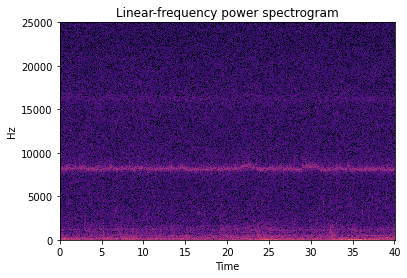

In [ ]:
## Señal con ruido
file_pathname = list_file[0]
## Se puede aplicar offset para no cargar todo el archivo
y, sr = librosa.load(file_pathname, sr=50000, offset=50, duration=40)

## Espectrograma: 
fig, ax = plt.subplots(sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax)
ax.set(title='Linear-frequency power spectrogram')
ax.label_outer()

plt.show()

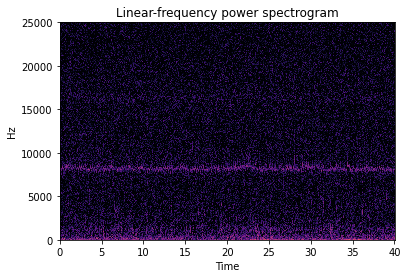

In [ ]:
## Señal sin ruido: 
file_pathname = list_file[0]

## Se puede aplicar offset para no cargar todo el archivo
y, sr = librosa.load(file_pathname, sr=50000, offset=50, duration=40)
Y = audio_to_frames(y, win_s, hop_size, fs)
est_Mn, est_Pn = noise_estimation_snr(Y)
est_Sx_oversub = spec_oversubtract(Y, est_Pn)
x_hat_oversub = frames_to_audio(est_Sx_oversub, win_s, hop_size, fs)

## Espectrograma: 
fig2, ax2 = plt.subplots(sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x_hat_oversub)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time', sr=sr, ax=ax2)
ax2.set(title='Linear-frequency power spectrogram')
ax2.label_outer()

plt.show()